In [ ]:
!pip install sentence_transformers transformers accelerate bitsandbytes datasets openpyxl pandas textstat

Pipeline for generation of codes, themes and subthemes

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import json
import pandas as pd
from typing import List, Dict
from pydantic import BaseModel, Field, validator

# Initialize the LLaMA model and tokenizer
model_name = "meta-llama/Llama-2-7b-chat-hf"
access_token = " "
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", load_in_4bit=True, use_auth_token=access_token)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, use_auth_token=access_token)
generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Define Pydantic models for validation
class ExcerptCode(BaseModel):
    excerpt: str = Field(description="Relevant excerpt from the transcript")
    code: str = Field(description="Code generated that best represents the excerpts identified")

    @validator("code")
    def code_is_not_long(cls, value):
        size_code = len(value.split())
        if size_code < 2 or size_code > 5:
            raise ValueError(f"Each code must be between two to five words long. The code '{value}' is {size_code} words long.")
        return value

class ExcerptCodes(BaseModel):
    excerpt_code: List[ExcerptCode] = Field(description="List of excerpt and code generated")

class SubTheme(BaseModel):
    sub_theme: str = Field(description="Sub-theme identified under a main theme")

class Theme(BaseModel):
    theme: str = Field(description="Main theme that was identified")
    sub_themes: List[SubTheme] = Field(description="List of sub-themes under the main theme")
    codes: List[str] = Field(description="List of codes categorized by theme identified")

class Themes(BaseModel):
    themes: List[Theme] = Field(description="List of themes identified")

    @validator("themes")
    def themes_is_not_long(cls, value):
        size_list_themes = len(value)
        if size_list_themes > 6:
            raise ValueError(f"The number of themes must not exceed 6. {size_list_themes} were generated.")
        return value

def _clean_themes_data(themes):
    unique_codes = set()
    themes_with_unique_codes = []

    for theme_data in themes["themes"]:
        theme = theme_data["theme"]
        codes = theme_data["codes"]
        cleaned_codes = list(set([code.replace("_", " ") for code in codes]))
        unique_codes.update(cleaned_codes)
        sub_themes = [sub_theme.sub_theme for sub_theme in theme_data.get("sub_themes", [])]
        theme_entry = {
            "theme": theme,
            "sub_themes": sub_themes,
            "codes": list(set(cleaned_codes))
        }
        themes_with_unique_codes.append(theme_entry)
    themes["themes"] = themes_with_unique_codes
    return themes

def _clean_codes_data(codes):
    return [{"excerpt": k, "code": v.replace("_", " ")} for k, v in json.loads(codes).items()]

def parse_codes(_codes, _themes):
    cleaned_data_dict = {"Theme": [], "Sub-Themes": [], "Codes": [], "Excerpts from transcript": []}
    json1_data = json.loads(_codes)
    json2_data = json.loads(_themes)

    for theme_data in json2_data["themes"]:
        theme = theme_data["theme"]
        sub_themes = ", ".join(theme_data.get("sub_themes", []))
        codes = set(theme_data["codes"])
        code = ", ".join([d.replace("_", " ") for d in codes])
        cleaned_data_dict["Theme"].append(theme)
        cleaned_data_dict["Sub-Themes"].append(sub_themes)
        cleaned_data_dict["Codes"].append(code)
        excerpts_combined = []
        for c in codes:
            if c in json1_data.keys():
                excerpts_combined.append(json1_data[c])
        excerpts_combined = set(excerpts_combined)
        cleaned_data_dict["Excerpts from transcript"].append(", ".join(excerpts_combined))

    return pd.DataFrame(cleaned_data_dict)

def generate_text(prompt: str, max_new_tokens: int = 100) -> str:
    """Generate text from a given prompt using the LLaMA model."""
    result = generator(prompt, max_new_tokens=max_new_tokens, num_return_sequences=1)
    return result[0]['generated_text'].strip()
def save_to_txt(summary: str, codes: str, themes: str, output_file: str):
    """
    Save summary, codes, and themes to a .txt file.
    """
    with open(output_file, 'w') as f:
        f.write("Summary:\n")
        f.write(summary + "\n\n")

        f.write("Codes:\n")
        f.write(codes + "\n\n")

        f.write("Themes and Sub-Themes:\n")
        f.write(themes + "\n\n")

    print(f"Output saved to {output_file}")

def process_transcript_and_save(file_path: str, output_file: str):
    """
    Process the transcript to extract summary, codes, and themes.
    Save the raw outputs (codes and themes) to a .txt file.
    """
    # Read the transcript from the .txt file
    with open(file_path, 'r') as file:
        transcript = file.read()

    # Generate summary
    summary_prompt = f"Summarise the following interview transcript based on Sports interviews:\n{transcript}\nSummary:"
    summary = generate_text(summary_prompt, max_new_tokens=200).strip()

    # Generate codes (raw output)
    codes_prompt = f"""
    Review the following interview transcript and identify key phrases or codes that represent significant parts of the conversation from the interview script.
    Each code should be a short phrase or term.

    Transcript:
    {transcript}

    Codes:"""
    codes = generate_text(codes_prompt, max_new_tokens=300).strip()

    # Generate themes and sub-themes (raw output)
    themes_prompt = f"""
    Based on the following codes, identify broad themes that categorise the key points from the interview transcript.
    For each theme, identify relevant sub-themes.

    Codes:
    {codes}

    Themes and Sub-Themes:"""
    themes = generate_text(themes_prompt, max_new_tokens=300).strip()

    # Debugging: Print outputs (to see what the model is generating)
    print("Generated Codes:\n", codes)
    print("Generated Themes:\n", themes)

    # Save the outputs to a .txt file
    save_to_txt(summary, codes, themes, output_file)

# Example usage
input_file = "/content/RahulDravid_TA.txt"  # Input file path for the transcript
output_file = "Thematic_analysis_output.txt"  # Output .txt file path

# Process transcript and save codes/themes to a text file
process_transcript_and_save(input_file, output_file)



/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:469: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:786: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

<ipython-input-2-1712005ecf4d>:19: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.9/migration/
  @validator("code")
<ipython-input-2-1712005ecf4d>:40: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.9/migration/
  @validator("themes")
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:435: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed

Generated Codes:
 Review the following interview transcript and identify key phrases or codes that represent significant parts of the conversation from the interview script.
    Each code should be a short phrase or term.

    Transcript:
    Q. Rahul, end of the campaign, must be disappointed with the result?

RAHUL DRAVID: Yeah, obviously disappointed to finish in the semifinals. Probably would have certainly liked to go a couple of steps further. But yeah, just outplayed, outclassed today. They were the better team in all departments really. The score line showed that.

Q. Unfortunately you won't be going to Melbourne, but there will be some takeaways for you from this tournament; what will you think about that?

RAHUL DRAVID: Yeah, it's tough after a loss like that. It's tough to -- but we'll reflect on it. It's tough to reflect on things so close to the result, but yeah, I think overall we ran a pretty good campaign.

Over the last year, we've played some good T20 cricket. Even in

In [ ]:
!pip install networkx matplotlib



Below is a simple network graph showing the categorisation of thmes and subthemes

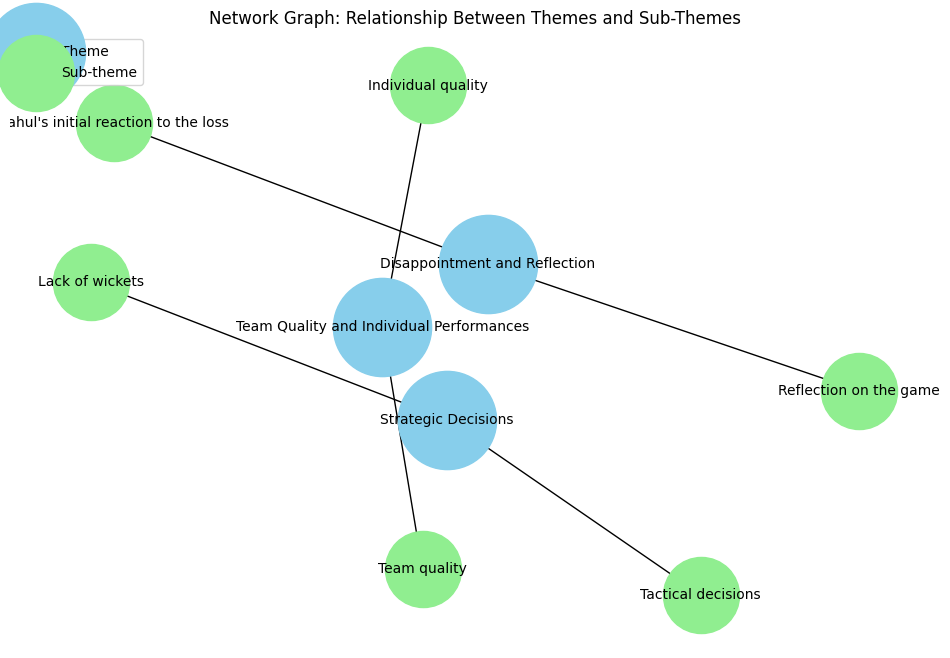

In [ ]:
# Draw the graph
pos = nx.spring_layout(G, k=0.5, iterations=20)  # Adjust these parameters as needed
plt.figure(figsize=(12, 8))

# Draw nodes with different colors for themes and sub-themes
nx.draw_networkx_nodes(G, pos, node_size=5000, nodelist=[n for n in G.nodes if G.nodes[n]['label'] == 'Theme'], node_color='skyblue', label='Theme')
nx.draw_networkx_nodes(G, pos, node_size=3000, nodelist=[n for n in G.nodes if G.nodes[n]['label'] == 'Sub-theme'], node_color='lightgreen', label='Sub-theme')

# Draw edges
nx.draw_networkx_edges(G, pos)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Show the legend
plt.legend(['Theme', 'Sub-theme'], loc='upper left')

# Show plot
plt.title("Network Graph: Relationship Between Themes and Sub-Themes")
plt.axis('off')  # Turn off axis
plt.show()


# Cohen's Kappa score for Themes and subthemes generated by Researcher 1 and the LLM





In [ ]:
# Install the NLTK library
!pip install nltk

# Import NLTK and download 'punkt' for tokenization and 'stopwords' for removing stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Calculating Cohen Kappa score with researcher and the LLM to get level of interpretation

In [ ]:
from sklearn.metrics import cohen_kappa_score
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Sample data - these should be replaced with your actual themes
themes_llm = [
    "Disappointment with the result of the campaign",
    "Reflection on the campaign",
    "Challenges faced by Indian cricket",
    "Performance of English players",
    "Tactics and strategy",
    "Debate over allowing Indian players to play in overseas T20 leagues"
]

themes_researcher = [
    "Disappointment and reflection",
    "Aware of opponents' strength",
    "Challenge in managing Indian Cricket and participation in overseas cricket by Indian cricket players",
    "UNFAVOURABLE FACTORS IMPACTING THE TEAM’S PERFORMANCE",
    "Respect for opponent's tactics",
    "the future of Indian players"
]

# Categories and associated keywords
categories_keywords = {
    "Campaign Reflection": ["disappointment", "reflection", "result", "campaign"],
    "Challenges": ["challenges", "managing", "difficulty", "hardship", "indian cricket"],
    "Performance": ["performance", "factors impacting", "unfavourable", "strength"],
    "Tactics": ["tactics", "strategy", "opponents", "aware", "respect"],
    "Overseas Participation": ["overseas", "participation", "future", "leagues"]
}

# Function to preprocess text by lowering case and removing non-alphanumeric characters and stopwords
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()  # Lowercase text
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    tokens = word_tokenize(text)  # Tokenize text
    filtered_tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    return " ".join(filtered_tokens)

# Function to map themes to categories based on keyword matching
def map_theme_to_category(theme, category_keywords):
    theme_processed = preprocess_text(theme)
    category_scores = {}
    for category, keywords in category_keywords.items():
        score = sum(theme_processed.count(keyword) for keyword in keywords)
        category_scores[category] = score
    assigned_category = max(category_scores, key=category_scores.get)
    return assigned_category if category_scores[assigned_category] > 0 else "Uncategorized"

# Map themes to categories
categories_llm = [map_theme_to_category(theme, categories_keywords) for theme in themes_llm]
categories_researcher = [map_theme_to_category(theme, categories_keywords) for theme in themes_researcher]

# Calculate Cohen's Kappa Score
kappa_score = cohen_kappa_score(categories_llm, categories_researcher)

# Print mapped categories and kappa score
print("Mapped Categories LLM:", categories_llm)
print("Mapped Categories Researcher:", categories_researcher)
print(f"Cohen's Kappa Score: {kappa_score}")

# Interpreting the result based on the scale provided for Themes
print("Interpretation for Themes:")
if kappa_score > 0.81:
    print("Excellent agreement.")
elif kappa_score > 0.61:
    print("Substantial agreement.")
elif kappa_score > 0.41:
    print("Moderate agreement.")
elif kappa_score > 0.21:
    print("Fair agreement.")
elif kappa_score > 0.01:
    print("Slight agreement.")
else:
    print("Poor agreement.")


Mapped Categories LLM: ['Campaign Reflection', 'Campaign Reflection', 'Challenges', 'Performance', 'Tactics', 'Overseas Participation']
Mapped Categories Researcher: ['Campaign Reflection', 'Tactics', 'Challenges', 'Performance', 'Tactics', 'Overseas Participation']
Cohen's Kappa Score: 0.7931034482758621
Interpretation for Themes:
Substantial agreement.


In [ ]:
pip install pandas matplotlib seaborn


In [ ]:
pip install matplotlib networkx


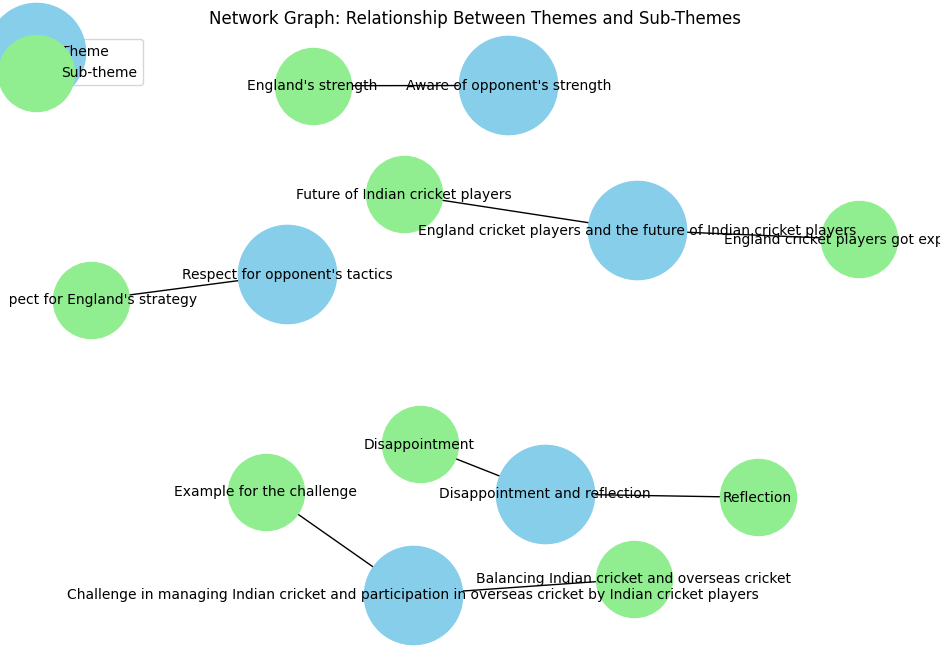

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Initialize graph
G = nx.Graph()

# Define themes and sub-themes
themes_subthemes = {
    "Disappointment and reflection": ["Disappointment", "Reflection"],
    "Aware of opponent's strength": ["England's strength"],
    "England cricket players and the future of Indian cricket players": ["England cricket players got experience", "Future of Indian cricket players"],
    "Challenge in managing Indian cricket and participation in overseas cricket by Indian cricket players": ["Balancing Indian cricket and overseas cricket", "Example for the challenge"],
    "Respect for opponent's tactics": ["Respect for England's strategy"]
}

# Add nodes and edges
for theme, subthemes in themes_subthemes.items():
    G.add_node(theme, label='Theme')  # Add theme node
    for subtheme in subthemes:
        G.add_node(subtheme, label='Sub-theme')  # Add sub-theme node
        G.add_edge(theme, subtheme)  # Add edge between theme and sub-theme

# Layout for the network graph
pos = nx.spring_layout(G, k=0.5, iterations=20)

# Create figure
plt.figure(figsize=(12, 8))

# Draw nodes with different colors for themes and sub-themes
nx.draw_networkx_nodes(G, pos, node_size=5000, nodelist=[n for n in G.nodes if G.nodes[n]['label'] == 'Theme'], node_color='skyblue', label='Theme')
nx.draw_networkx_nodes(G, pos, node_size=3000, nodelist=[n for n in G.nodes if G.nodes[n]['label'] == 'Sub-theme'], node_color='lightgreen', label='Sub-theme')

# Draw edges
nx.draw_networkx_edges(G, pos)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Show the legend
plt.legend(['Theme', 'Sub-theme'], loc='upper left')

# Show plot
plt.title("Network Graph: Relationship Between Themes and Sub-Themes")
plt.axis('off')  # Turn off axis
plt.show()


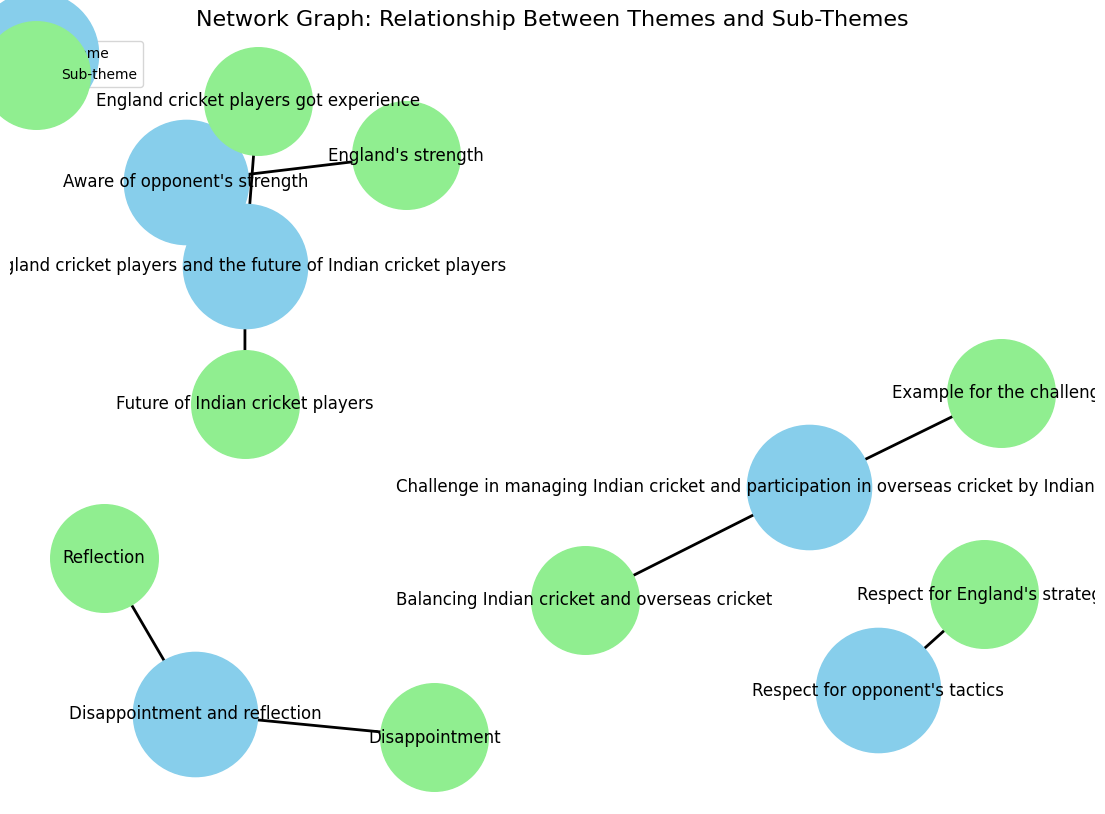

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Initialize graph
G = nx.Graph()

# Define themes and sub-themes
themes_subthemes = {
    "Disappointment and reflection": ["Disappointment", "Reflection"],
    "Aware of opponent's strength": ["England's strength"],
    "England cricket players and the future of Indian cricket players": ["England cricket players got experience", "Future of Indian cricket players"],
    "Challenge in managing Indian cricket and participation in overseas cricket by Indian cricket players": ["Balancing Indian cricket and overseas cricket", "Example for the challenge"],
    "Respect for opponent's tactics": ["Respect for England's strategy"]
}

# Add nodes and edges
for theme, subthemes in themes_subthemes.items():
    G.add_node(theme, label='Theme')  # Add theme node
    for subtheme in subthemes:
        G.add_node(subtheme, label='Sub-theme')  # Add sub-theme node
        G.add_edge(theme, subtheme)  # Add edge between theme and sub-theme

# Layout for the network graph, with better spacing for visibility
pos = nx.spring_layout(G, k=0.7, iterations=50)

# Create figure
plt.figure(figsize=(14, 10))

# Draw nodes with increased size and different colors for themes and sub-themes
nx.draw_networkx_nodes(G, pos, node_size=8000, nodelist=[n for n in G.nodes if G.nodes[n]['label'] == 'Theme'], node_color='skyblue', label='Theme')
nx.draw_networkx_nodes(G, pos, node_size=6000, nodelist=[n for n in G.nodes if G.nodes[n]['label'] == 'Sub-theme'], node_color='lightgreen', label='Sub-theme')

# Draw edges with thicker lines for better visibility
nx.draw_networkx_edges(G, pos, width=2)

# Draw labels with larger font for better visibility
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

# Show the legend
plt.legend(['Theme', 'Sub-theme'], loc='upper left')

# Show plot with title
plt.title("Network Graph: Relationship Between Themes and Sub-Themes", fontsize=16)
plt.axis('off')  # Turn off axis
plt.show()


In [ ]:
# Define themes and sub-themes in a simple dictionary structure
themes_subthemes = {
    "Disappointment and reflection": ["Disappointment", "Reflection"],
    "Aware of opponent's strength": ["England's strength"],
    "England cricket players and the future of Indian cricket players": ["England cricket players got experience", "Future of Indian cricket players"],
    "Challenge in managing Indian cricket and participation in overseas cricket by Indian cricket players": ["Balancing Indian cricket and overseas cricket", "Example for the challenge"],
    "UNFAVOURABLE FACTORS IMPACTING THE TEAM’S PERFORMANCE":["underperformance"],
    "Respect for opponent's tactics": ["Respect for England's strategy"]
}

# Function to print themes and sub-themes in a categorized manner
def print_themes_and_subthemes(themes_subthemes):
    for theme, subthemes in themes_subthemes.items():
        print(f"Theme: {theme}")
        for subtheme in subthemes:
            print(f"  Sub-theme: {subtheme}")
        print()  # Add an empty line for better readability

# Call the function to print the categorized themes and sub-themes
print_themes_and_subthemes(themes_subthemes)


Theme: Disappointment and reflection
  Sub-theme: Disappointment
  Sub-theme: Reflection

Theme: Aware of opponent's strength
  Sub-theme: England's strength

Theme: England cricket players and the future of Indian cricket players
  Sub-theme: England cricket players got experience
  Sub-theme: Future of Indian cricket players

Theme: Challenge in managing Indian cricket and participation in overseas cricket by Indian cricket players
  Sub-theme: Balancing Indian cricket and overseas cricket
  Sub-theme: Example for the challenge

Theme: UNFAVOURABLE FACTORS IMPACTING THE TEAM’S PERFORMANCE
  Sub-theme: underperformance

Theme: Respect for opponent's tactics
  Sub-theme: Respect for England's strategy



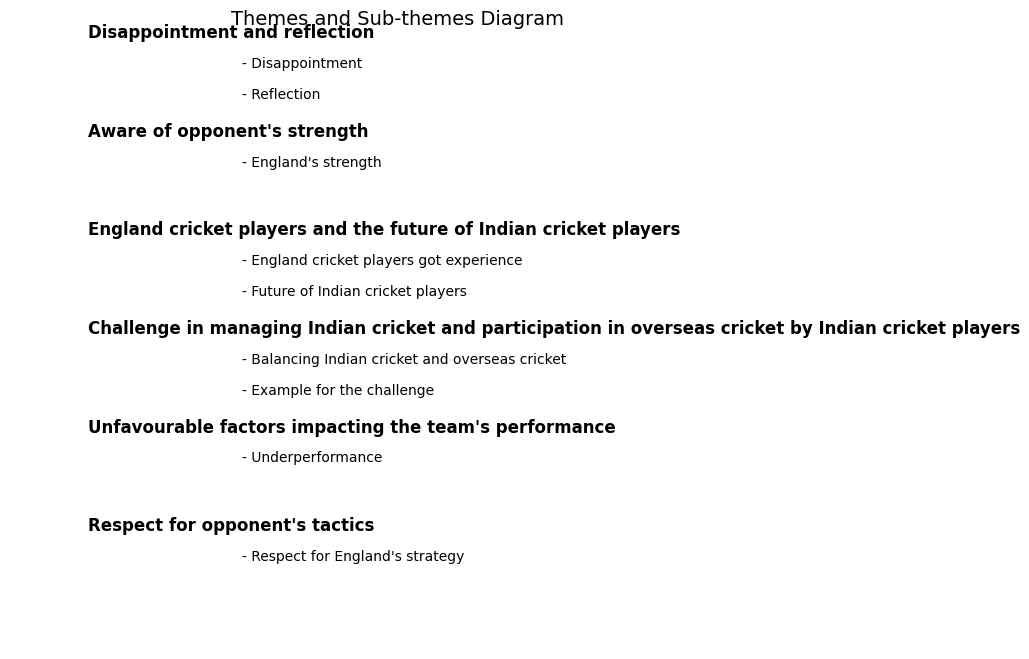

In [ ]:

import matplotlib.pyplot as plt

# Define themes and sub-themes
themes_subthemes = {
    "Disappointment and reflection": ["Disappointment", "Reflection"],
    "Aware of opponent's strength": ["England's strength"],
    "England cricket players and the future of Indian cricket players": ["England cricket players got experience", "Future of Indian cricket players"],
    "Challenge in managing Indian cricket and participation in overseas cricket by Indian cricket players": ["Balancing Indian cricket and overseas cricket", "Example for the challenge"],
    "Unfavourable factors impacting the team's performance": ["Underperformance"],
    "Respect for opponent's tactics": ["Respect for England's strategy"]
}

# Setup the plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# Vertical position for each theme, equally spaced
vertical_positions = range(100, 0, -int(100 / len(themes_subthemes)))

# Create the plot
for idx, (theme, subthemes) in enumerate(themes_subthemes.items()):
    vpos = vertical_positions[idx]
    # Plot the theme
    ax.text(10, vpos, theme, fontsize=12, fontweight='bold', va='center')

    # Plot each sub-theme
    for i, subtheme in enumerate(subthemes):
        ax.text(30, vpos - (i + 1) * 5, f'- {subtheme}', fontsize=10, va='center')

# Remove axes
ax.axis('off')

# Set the title
plt.title('Themes and Sub-themes Diagram', fontsize=14)

# Show the plot
plt.show()


In [ ]:
import plotly.graph_objects as go

fig = go.Figure(go.Treemap(
    labels=["Disappointment and reflection", "Disappointment", "Reflection",
            "Aware of opponent's strength", "England's strength",
            "England cricket players and the future of Indian cricket players",
            "England cricket players got experience", "Future of Indian cricket players",
            "Challenge in managing Indian cricket", "Balancing Indian cricket and overseas cricket",
            "Example for the challenge", "Unfavourable factors", "Underperformance",
            "Respect for opponent's tactics", "Respect for England's strategy"],
    parents=["", "Disappointment and reflection", "Disappointment and reflection",
             "", "Aware of opponent's strength",
             "", "England cricket players and the future of Indian cricket players",
             "England cricket players and the future of Indian cricket players",
             "", "Challenge in managing Indian cricket",
             "Challenge in managing Indian cricket", "", "Unfavourable factors",
             "", "Respect for opponent's tactics"],
    values=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # Dummy values to enable tree structure
))

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))

fig.show()


In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=["Theme: Disappointment", "Disappointment", "Reflection",
             "Theme: Opponent's Strength", "England's Strength",
             "Theme: England Cricket Future", "England Experience", "Future of Indian Players"],
    ),
    link=dict(
      source=[0, 0, 3, 3, 5, 5],  # indices correspond to labels
      target=[1, 2, 4, 4, 6, 7],
      value=[1, 1, 1, 1, 1, 1]
    ))])

fig.update_layout(title_text="Flow of Themes and Sub-themes", font_size=10)
fig.show()


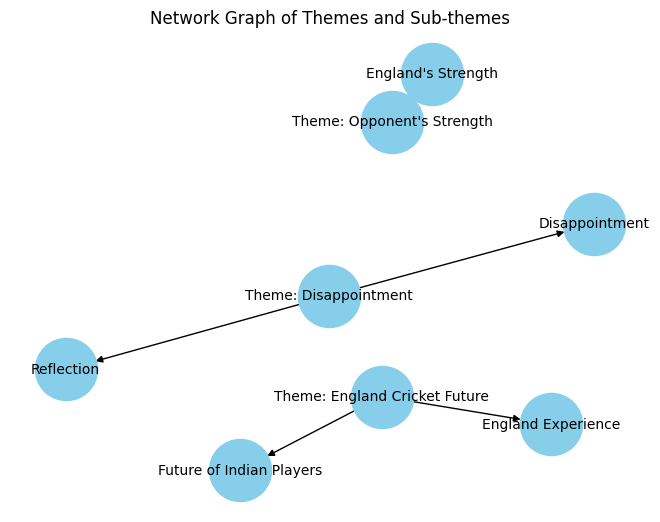

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()
edges = [
    ("Theme: Disappointment", "Disappointment"),
    ("Theme: Disappointment", "Reflection"),
    ("Theme: Opponent's Strength", "England's Strength"),
    ("Theme: England Cricket Future", "England Experience"),
    ("Theme: England Cricket Future", "Future of Indian Players")
]

G.add_edges_from(edges)

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='k', linewidths=1, font_size=10)

plt.title('Network Graph of Themes and Sub-themes')
plt.show()


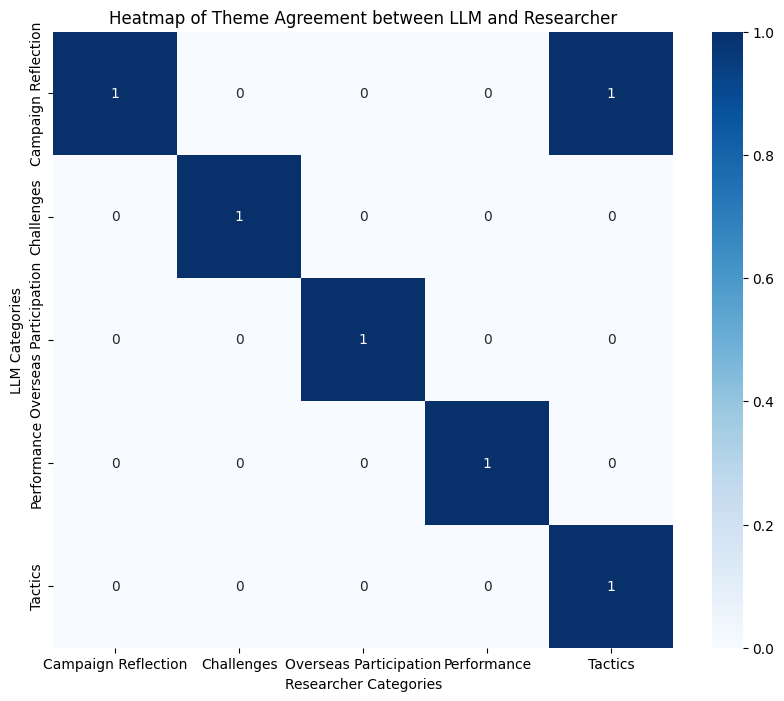

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Mapped Categories from LLM and Researcher
categories_llm = ['Campaign Reflection', 'Campaign Reflection', 'Challenges', 'Performance', 'Tactics', 'Overseas Participation']
categories_researcher = ['Campaign Reflection', 'Tactics', 'Challenges', 'Performance', 'Tactics', 'Overseas Participation']

# Create a DataFrame to count occurrences
df = pd.DataFrame({
    'LLM': categories_llm,
    'Researcher': categories_researcher
})

# Create a cross-tabulation to form a matrix of counts
matrix = pd.crosstab(df['LLM'], df['Researcher'])

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Heatmap of Theme Agreement between LLM and Researcher')
plt.xlabel('Researcher Categories')
plt.ylabel('LLM Categories')
plt.show()


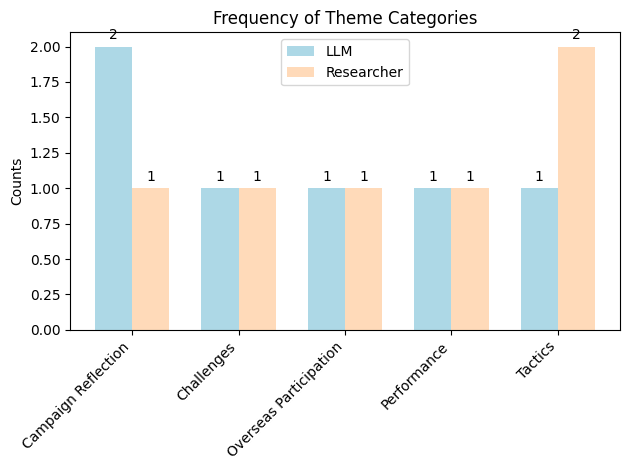

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Mapped Categories from LLM and Researcher
categories_llm = ['Campaign Reflection', 'Campaign Reflection', 'Challenges', 'Performance', 'Tactics', 'Overseas Participation']
categories_researcher = ['Campaign Reflection', 'Tactics', 'Challenges', 'Performance', 'Tactics', 'Overseas Participation']

# Count frequency of each category
def count_frequency(categories):
    freq_dict = {}
    for item in categories:
        if item in freq_dict:
            freq_dict[item] += 1
        else:
            freq_dict[item] = 1
    return freq_dict

llm_freq = count_frequency(categories_llm)
researcher_freq = count_frequency(categories_researcher)

# Labels and frequencies for plotting
labels = sorted(set(categories_llm + categories_researcher))
llm_counts = [llm_freq.get(label, 0) for label in labels]
researcher_counts = [researcher_freq.get(label, 0) for label in labels]

x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, llm_counts, width, label='LLM', color='lightblue')
rects2 = ax.bar(x + width/2, researcher_counts, width, label='Researcher', color='peachpuff')

# Add text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Frequency of Theme Categories')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()


# BLEU Scores For Theme Comparisons (LLM Vs Researcher_1)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Themes from LLM
themes_llm = [
    "Disappointment with the result of the campaign",
    "Reflection on the campaign",
    "Challenges faced by Indian cricket",
    "Performance of English players",
    "Tactics and strategy",
    "Debate over allowing Indian players to play in overseas T20 leagues"
]

# Themes from Researcher
themes_researcher = [
    "Disappointment and reflection",
    "Aware of opponents' strength",
    "Challenge in managing Indian Cricket and participation in overseas cricket by Indian cricket players",
    "UNFAVOURABLE FACTORS IMPACTING THE TEAM’S PERFORMANCE",
    "Respect for opponent's tactics",
    "the future of Indian players"
]

# Function to preprocess text by lowering case and removing non-alphanumeric characters and stopwords
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()  # Lowercase text
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    tokens = word_tokenize(text)  # Tokenize text
    filtered_tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    return " ".join(filtered_tokens)

# Preprocess both sets of themes
preprocessed_themes_llm = [preprocess_text(theme) for theme in themes_llm]
preprocessed_themes_researcher = [preprocess_text(theme) for theme in themes_researcher]

# Smoothing function for BLEU score
smooth_fn = SmoothingFunction().method1

# Calculate BLEU score for each pair of LLM theme and researcher theme with smoothing
def calculate_bleu_with_smoothing(llm_themes, researcher_themes):
    total_bleu_score = 0.0
    for llm_theme, researcher_theme in zip(llm_themes, researcher_themes):
        reference = [researcher_theme.split()]  # BLEU requires reference as a list of lists
        candidate = llm_theme.split()
        bleu_score = sentence_bleu(reference, candidate, smoothing_function=smooth_fn)
        total_bleu_score += bleu_score
        print(f"BLEU score for LLM theme: \"{llm_theme}\" vs Researcher theme: \"{researcher_theme}\": {bleu_score}")

    # Calculate the combined average BLEU score
    combined_bleu_score = total_bleu_score / len(llm_themes)
    return combined_bleu_score

# Calculate the BLEU score with smoothing for all theme pairs
combined_bleu_score = calculate_bleu_with_smoothing(preprocessed_themes_llm, preprocessed_themes_researcher)

# Print the combined BLEU score for the entire set of themes
print(f"\nCombined BLEU Score for all themes: {combined_bleu_score}")



BLEU score for LLM theme: "disappointment result campaign" vs Researcher theme: "disappointment reflection": 0.11362193664674995
BLEU score for LLM theme: "reflection campaign" vs Researcher theme: "aware opponents strength": 0
BLEU score for LLM theme: "challenges faced indian cricket" vs Researcher theme: "challenge managing indian cricket participation overseas cricket indian cricket players": 0.03791080144520064
BLEU score for LLM theme: "performance english players" vs Researcher theme: "unfavourable factors impacting team performance": 0.05833544737207805
BLEU score for LLM theme: "tactics strategy" vs Researcher theme: "respect opponent tactics": 0.09069748827745895
BLEU score for LLM theme: "debate allowing indian players play overseas t20 leagues" vs Researcher theme: "future indian players": 0.05873949094699214

Combined BLEU Score for all themes: 0.059884194114746624


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


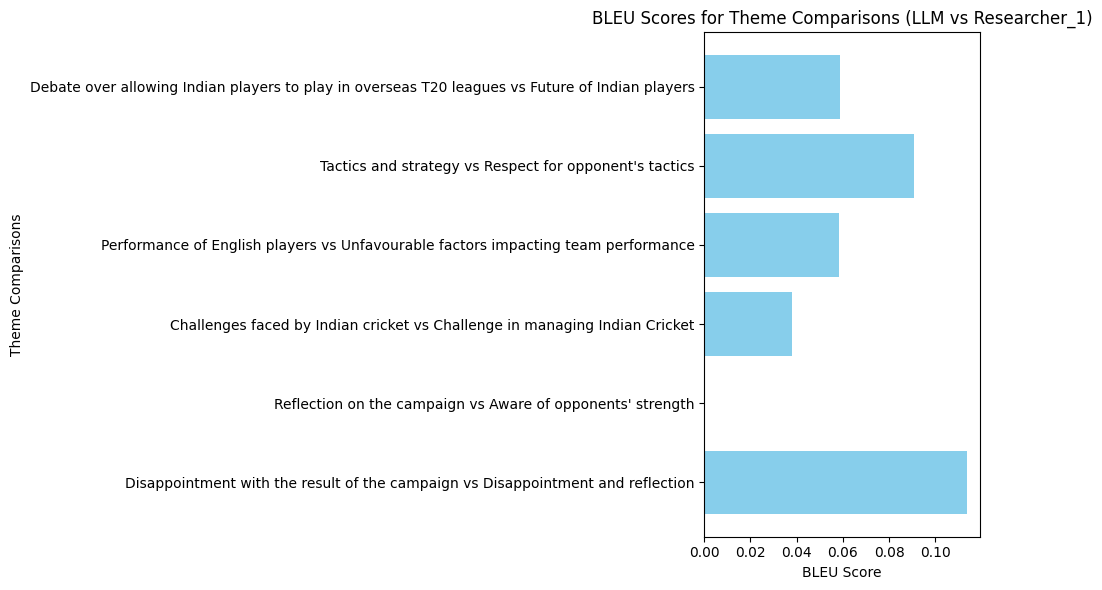

In [ ]:
import matplotlib.pyplot as plt

# Themes and corresponding BLEU scores
themes = [
    "Disappointment with the result of the campaign vs Disappointment and reflection",
    "Reflection on the campaign vs Aware of opponents' strength",
    "Challenges faced by Indian cricket vs Challenge in managing Indian Cricket",
    "Performance of English players vs Unfavourable factors impacting team performance",
    "Tactics and strategy vs Respect for opponent's tactics",
    "Debate over allowing Indian players to play in overseas T20 leagues vs Future of Indian players"
]

bleu_scores = [
    0.11362193664674995,
    0,
    0.03791080144520064,
    0.05833544737207805,
    0.09069748827745895,
    0.05873949094699214
]

# Plotting the BLEU scores as a bar chart
plt.figure(figsize=(10, 6))
plt.barh(themes, bleu_scores, color='skyblue')
plt.xlabel("BLEU Score")
plt.ylabel("Theme Comparisons")
plt.title("BLEU Scores for Theme Comparisons (LLM vs Researcher_1)")
plt.tight_layout()
plt.show()


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from sklearn.metrics import cohen_kappa_score
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Sub-themes from LLM and Researcher
subthemes_llm = [
    "Rahul's initial reaction to the loss",
    "Reflection on the game",
    "Team quality",
    "Individual quality",
    "Lack of wickets",
    "Future prospects of Indian players",
    "Tactical decisions",
    "Opponent analysis"
]

subthemes_researcher = [
    "Disappointment",
    "Reflection",
    "England's strength",
    "England cricket players got experience",
    "Future of Indian cricket players",
    "Balancing Indian cricket and overseas cricket",
    "Example for the challenge",
    "Respect for England's strategy"
]

# Function to preprocess text by lowering case and removing non-alphanumeric characters and stopwords
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)

# Function to map subthemes to categories based on keyword matching
def map_to_categories(data, keywords):
    mapped = []
    for item in data:
        item_processed = preprocess_text(item)
        category_scores = {category: sum(item_processed.count(keyword) for keyword in keywords[category]) for category in keywords}
        if category_scores and max(category_scores.values()) > 0:
            assigned_category = max(category_scores, key=category_scores.get)
            mapped.append(assigned_category)
        else:
            mapped.append("Uncategorized")
    return mapped

# Define categories and associated keywords
category_keywords = {
    "Campaign Reflection": ["disappointment", "reflection", "campaign"],
    "Challenges": ["challenges", "managing", "hardship"],
    "Performance": ["performance", "evaluation", "team quality"],
    "Tactics": ["strategy", "tactical decisions", "opponent analysis"],
    "Overseas Participation": ["overseas", "international", "leagues"]
}

# Apply mapping to subthemes
mapped_subthemes_llm = map_to_categories(subthemes_llm, category_keywords)
mapped_subthemes_researcher = map_to_categories(subthemes_researcher, category_keywords)

# Calculate Cohen's Kappa Score for Sub-Themes
kappa_score_subthemes = cohen_kappa_score(mapped_subthemes_llm, mapped_subthemes_researcher)

# Print Cohen's Kappa Score
print(f"Cohen's Kappa Score for Sub-Themes: {kappa_score_subthemes:.2f}")

# Interpretation for Sub-Themes
print("\nInterpretation for Sub-Themes:")
if kappa_score_subthemes > 0.81:
    print("Excellent agreement.")
elif kappa_score_subthemes > 0.61:
    print("Substantial agreement.")
elif kappa_score_subthemes > 0.41:
    print("Moderate agreement.")
elif kappa_score_subthemes > 0.21:
    print("Fair agreement.")
elif kappa_score_subthemes > 0.01:
    print("Slight agreement.")
else:
    print("Poor agreement.")


Cohen's Kappa Score for Sub-Themes: 0.27

Interpretation for Sub-Themes:
Fair agreement.


In [ ]:
from sklearn.metrics import cohen_kappa_score
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Themes and Sub-themes extraction from LLM and Researcher
themes_llm = [
    "Disappointment with the result of the campaign",
    "Reflection on the campaign",
    "Challenges faced by Indian cricket",
    "Performance of English players",
    "Tactics and strategy",
    "Debate over allowing Indian players to play in overseas T20 leagues"
]

subthemes_llm = [
   "Rahul's initial reaction to the loss",
    "Reflection on the game",
    "Team quality",
    "Individual quality",
    "Lack of wickets",
    "Future prospects of Indian players",
    "Tactical decisions",
    "Opponent analysis"
]

themes_researcher = [
    "Disappointment and reflection",
    "Aware of opponents' strength",
    "England cricket players and the future of Indian cricket players",
    "Challenge in managing Indian Cricket and participation in overseas cricket by Indian cricket players",
    "UNFAVOURABLE FACTORS IMPACTING THE TEAM’S PERFORMANCE",
    "Respect for opponent's tactics"
]

subthemes_researcher = [
    "Disappointment",
    "Reflection",
    "England's strength",
    "England cricket players got experience",
    "Future of Indian cricket players",
    "Balancing Indian cricket and overseas cricket",
    "Example for the challenge",
    "Respect for England's strategy"
]

# Function to preprocess text
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)

# Function to map themes and subthemes to categories
def map_to_categories(data, keywords):
    mapped = []
    for item in data:
        item_processed = preprocess_text(item)
        category_scores = {category: sum(item_processed.count(keyword) for keyword in keywords[category]) for category in keywords}
        if category_scores and max(category_scores.values()) > 0:
            assigned_category = max(category_scores, key=category_scores.get)
            mapped.append(assigned_category)
        else:
            mapped.append("Uncategorized")
    return mapped

# Define categories and associated keywords
category_keywords = {
    "Campaign Reflection": ["disappointment", "reflection", "campaign"],
    "Challenges": ["challenges", "managing", "hardship"],
    "Performance": ["performance", "evaluation", "team quality"],
    "Tactics": ["strategy", "tactical decisions", "opponent analysis"],
    "Overseas Participation": ["overseas", "international", "leagues"]
}

# Apply mapping to themes and subthemes
mapped_themes_llm = map_to_categories(themes_llm, category_keywords)
mapped_themes_researcher = map_to_categories(themes_researcher, category_keywords)
mapped_subthemes_llm = map_to_categories(subthemes_llm, category_keywords)
mapped_subthemes_researcher = map_to_categories(subthemes_researcher, category_keywords)

# Calculate Cohen's Kappa Scores
kappa_score_themes = cohen_kappa_score(mapped_themes_llm, mapped_themes_researcher)
kappa_score_subthemes = cohen_kappa_score(mapped_subthemes_llm, mapped_subthemes_researcher)

# Interpretation for Themes
print("Interpretation for Themes:")
if kappa_score_themes > 0.81:
    print("Excellent agreement.")
elif kappa_score_themes > 0.61:
    print("Substantial agreement.")
elif kappa_score_themes > 0.41:
    print("Moderate agreement.")
elif kappa_score_themes > 0.21:
    print("Fair agreement.")
elif kappa_score_themes > 0.01:
    print("Slight agreement.")
else:
    print("Poor agreement.")

# Interpretation for Sub-Themes
print("\nInterpretation for Sub-Themes:")
if kappa_score_subthemes > 0.81:
    print("Excellent agreement.")
elif kappa_score_subthemes > 0.61:
    print("Substantial agreement.")
elif kappa_score_subthemes > 0.41:
    print("Moderate agreement.")
elif kappa_score_subthemes > 0.21:
    print("Fair agreement.")
elif kappa_score_subthemes > 0.01:
    print("Slight agreement.")
else:
    print("Poor agreement.")




Interpretation for Themes:
Slight agreement.

Interpretation for Sub-Themes:
Fair agreement.


# Accuracy, Jaccard Similarity, Precision, Recall, F1 Score for themes and subthemes generated by Researcher 1 and the LLM

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score
from sklearn.preprocessing import LabelBinarizer
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Sample data - LLM and Researcher themes
themes_llm = [
    "Disappointment with the result of the campaign",
    "Reflection on the campaign",
    "Challenges faced by Indian cricket",
    "Performance of English players",
    "Tactics and strategy",
    "Debate over allowing Indian players to play in overseas T20 leagues"
]

themes_researcher = [
    "Disappointment and reflection",
    "Aware of opponents' strength",
    "Challenge in managing Indian Cricket and participation in overseas cricket by Indian cricket players",
    "UNFAVOURABLE FACTORS IMPACTING THE TEAM’S PERFORMANCE",
    "Respect for opponent's tactics",
    "the future of Indian players"
]

# Categories and associated keywords
categories_keywords = {
    "Campaign Reflection": ["disappointment", "reflection", "result", "campaign"],
    "Challenges": ["challenges", "managing", "difficulty", "hardship", "indian cricket"],
    "Performance": ["performance", "factors impacting", "unfavourable", "strength"],
    "Tactics": ["tactics", "strategy", "opponents", "aware", "respect"],
    "Overseas Participation": ["overseas", "participation", "future", "leagues"]
}

# Function to preprocess text by lowering case and removing non-alphanumeric characters and stopwords
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()  # Lowercase text
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    tokens = word_tokenize(text)  # Tokenize text
    filtered_tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    return " ".join(filtered_tokens)

# Function to map themes to categories based on keyword matching
def map_theme_to_category(theme, category_keywords):
    theme_processed = preprocess_text(theme)
    category_scores = {}
    for category, keywords in category_keywords.items():
        score = sum(theme_processed.count(keyword) for keyword in keywords)
        category_scores[category] = score
    assigned_category = max(category_scores, key=category_scores.get)
    return assigned_category if category_scores[assigned_category] > 0 else "Uncategorized"

# Map themes to categories
categories_llm = [map_theme_to_category(theme, categories_keywords) for theme in themes_llm]
categories_researcher = [map_theme_to_category(theme, categories_keywords) for theme in themes_researcher]

# Binarize labels for further calculations
lb = LabelBinarizer()
binary_llm = lb.fit_transform(categories_llm)
binary_researcher = lb.transform(categories_researcher)

# Calculate Accuracy
accuracy = accuracy_score(categories_llm, categories_researcher)
print(f"Accuracy: {accuracy}")

# Calculate Jaccard Similarity
jaccard = jaccard_score(binary_llm, binary_researcher, average='macro')
print(f"Jaccard Similarity: {jaccard}")

# Calculate Precision, Recall, and F1 Score
precision = precision_score(binary_researcher, binary_llm, average='macro')
recall = recall_score(binary_researcher, binary_llm, average='macro')
f1 = f1_score(binary_researcher, binary_llm, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.8333333333333334
Jaccard Similarity: 0.8
Precision: 0.9
Recall: 0.9
F1 Score: 0.8666666666666666


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
from sklearn.preprocessing import LabelBinarizer

# Calculate Accuracy
accuracy_subthemes = accuracy_score(mapped_subthemes_researcher, mapped_subthemes_llm)

# Binarise labels for Jaccard, Precision, Recall, and F1 calculations
lb_subthemes = LabelBinarizer()
binary_subthemes_llm = lb_subthemes.fit_transform(mapped_subthemes_llm)
binary_subthemes_researcher = lb_subthemes.transform(mapped_subthemes_researcher)

# Calculate Jaccard Similarity
jaccard_subthemes = jaccard_score(binary_subthemes_llm, binary_subthemes_researcher, average='macro')

# Calculate Precision, Recall, and F1 Score
precision_subthemes = precision_score(binary_subthemes_researcher, binary_subthemes_llm, average='macro')
recall_subthemes = recall_score(binary_subthemes_researcher, binary_subthemes_llm, average='macro')
f1_subthemes = f1_score(binary_subthemes_researcher, binary_subthemes_llm, average='macro')

# Print the results
print(f"Accuracy: {accuracy_subthemes}")
print(f"Jaccard Similarity: {jaccard_subthemes}")
print(f"Precision: {precision_subthemes}")
print(f"Recall: {recall_subthemes}")
print(f"F1 Score: {f1_subthemes}")


Accuracy: 0.5
Jaccard Similarity: 0.3333333333333333
Precision: 0.5
Recall: 0.5
F1 Score: 0.4583333333333333


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Cohen's Kappa score for Themes and subthemes generated by Researcher 2 and the LLM

In [ ]:
from sklearn.metrics import cohen_kappa_score
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Themes from LLM and Researcher 2
themes_llm = [
    "Disappointment with the result of the campaign",
    "Reflection on the campaign",
    "Challenges faced by Indian cricket",
    "Performance of English players",
    "Tactics and strategy",
    "Debate over allowing Indian players to play in overseas T20 leagues"
]

themes_researcher_2 = [
    "Self-reflection on the match",
    "Acknowledging the opponent's strength",
    "Understanding team's potential",
    "Performance of English players",
    "Impact on future games",
    "Lesser Indian representation in overseas league"
]

# Preprocess text by lowering case and removing non-alphanumeric characters and stopwords
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)

# Map themes to categories
def map_to_categories(data, keywords):
    mapped = []
    for item in data:
        item_processed = preprocess_text(item)
        category_scores = {category: sum(item_processed.count(keyword) for keyword in keywords[category]) for category in keywords}
        if category_scores and max(category_scores.values()) > 0:
            assigned_category = max(category_scores, key=category_scores.get)
            mapped.append(assigned_category)
        else:
            mapped.append("Uncategorized")
    return mapped

# Define categories and associated keywords
category_keywords = {
    "Campaign Reflection": ["disappointment", "reflection", "campaign"],
    "Challenges": ["challenges", "managing", "hardship"],
    "Performance": ["performance", "evaluation", "team quality"],
    "Tactics": ["strategy", "tactical decisions", "opponent analysis"],
    "Overseas Participation": ["overseas", "international", "leagues"]
}

# Apply mapping to themes
mapped_themes_llm = map_to_categories(themes_llm, category_keywords)
mapped_themes_researcher_2 = map_to_categories(themes_researcher_2, category_keywords)

# Calculate Cohen's Kappa Score for Themes
kappa_score_themes = cohen_kappa_score(mapped_themes_llm, mapped_themes_researcher_2)

# Print the kappa score and interpretation for themes
print("Cohen's Kappa Score for Themes:", kappa_score_themes)
# Add the interpretation logic here as previously provided

# Interpretation for Themes
print("Interpretation for Themes:")
if kappa_score_themes > 0.81:
    print("Excellent agreement.")
elif kappa_score_themes > 0.61:
    print("Substantial agreement.")
elif kappa_score_themes > 0.41:
    print("Moderate agreement.")
elif kappa_score_themes > 0.21:
    print("Fair agreement.")
elif kappa_score_themes > 0.01:
    print("Slight agreement.")
else:
    print("Poor agreement.")


Cohen's Kappa Score for Themes: 0.4375000000000001
Interpretation for Themes:
Moderate agreement.


In [ ]:
# Subthemes from LLM and Researcher 2
subthemes_llm = [
   "Rahul's initial reaction to the loss",
    "Reflection on the game",
    "Team quality",
    "Individual quality",
    "Lack of wickets",
    "Future prospects of Indian players",
    "Tactical decisions",
    "Opponent analysis"
]

subthemes_researcher_2 = [
    "Disappointment",
    "Early and tough to reflect",
    "Lack of adequate team skill",
    "Outplayed and outclassed match",
    "Insufficient swinging of ball",
    "Powerful bowling",
    "In control of the match",
    "Played good shots right",
    "Counterattacked Indian spinners",
    "Proficient batting",
    "Great individual skills",
    "No haste in prediction",
    "Utilising future matches to hone skills",
    "Optimistic on next world cup",
    "Clashing with domestic league season",
    "Dependency on BCCI for decision-making",
    "Acknowledging the importance of Ranji trophy"
]

# Preprocess text by lowering case and removing non-alphanumeric characters and stopwords
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)

# Truncate the longer list to match the length of the shorter one
min_length = min(len(subthemes_llm), len(subthemes_researcher_2))
subthemes_llm = subthemes_llm[:min_length]
subthemes_researcher_2 = subthemes_researcher_2[:min_length]

# Apply mapping to subthemes
mapped_subthemes_llm = map_to_categories(subthemes_llm, category_keywords)
mapped_subthemes_researcher_2 = map_to_categories(subthemes_researcher_2, category_keywords)

# Calculate Cohen's Kappa Score for Subthemes
kappa_score_subthemes = cohen_kappa_score(mapped_subthemes_llm, mapped_subthemes_researcher_2)

# Print the kappa score and interpretation for subthemes
print("Cohen's Kappa Score for Subthemes:", kappa_score_subthemes)
# Add the interpretation logic here as previously provided

# Interpretation for Sub-Themes
print("\nInterpretation for Sub-Themes:")
if kappa_score_subthemes > 0.81:
    print("Excellent agreement.")
elif kappa_score_subthemes > 0.61:
    print("Substantial agreement.")
elif kappa_score_subthemes > 0.41:
    print("Moderate agreement.")
elif kappa_score_subthemes > 0.21:
    print("Fair agreement.")
elif kappa_score_subthemes > 0.01:
    print("Slight agreement.")
else:
    print("Poor agreement.")



Cohen's Kappa Score for Subthemes: -0.1428571428571428

Interpretation for Sub-Themes:
Poor agreement.


In [ ]:
pip install sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 15.3 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import cohen_kappa_score
from nltk.corpus import stopwords
import re
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Preprocess text by lowering case and removing non-alphanumeric characters and stopwords
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)

# Apply preprocessing to both lists
preprocessed_llm = [preprocess_text(theme) for theme in subthemes_llm]
preprocessed_researcher_2 = [preprocess_text(theme) for theme in subthemes_researcher_2]

# Use a pre-trained model for sentence embeddings (like BERT or similar)
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Convert both preprocessed lists into sentence embeddings
embeddings_llm = model.encode(preprocessed_llm)
embeddings_researcher_2 = model.encode(preprocessed_researcher_2)

# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings_llm, embeddings_researcher_2)

# Map each item in LLM subthemes to the most similar researcher subtheme
mapped_indices_llm = np.argmax(similarity_matrix, axis=1)
mapped_indices_researcher_2 = np.argmax(similarity_matrix.T, axis=1)

# Now calculate Cohen's Kappa Score on the mapped indices
kappa_score_subthemes = cohen_kappa_score(mapped_indices_llm, mapped_indices_researcher_2)

# Print the kappa score and interpretation for subthemes
print("Cohen's Kappa Score for Subthemes:", kappa_score_subthemes)

# Interpretation for Sub-Themes
print("\nInterpretation for Sub-Themes:")
if kappa_score_subthemes > 0.81:
    print("Excellent agreement.")
elif kappa_score_subthemes > 0.61:
    print("Substantial agreement.")
elif kappa_score_subthemes > 0.41:
    print("Moderate agreement.")
elif kappa_score_subthemes > 0.21:
    print("Fair agreement.")
elif kappa_score_subthemes > 0.01:
    print("Slight agreement.")
else:
    print("Poor agreement.")


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public m

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Cohen's Kappa Score for Subthemes: 0.4285714285714286

Interpretation for Sub-Themes:
Moderate agreement.


# Accuracy, Jaccard Similarity, Precision, Recall, F1 Score for themes and subthemes generated by Researcher 2 and the LLM



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
from sklearn.preprocessing import LabelBinarizer
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Themes from LLM and Researcher 2
themes_llm = [
    "Disappointment with the result of the campaign",
    "Reflection on the campaign",
    "Challenges faced by Indian cricket",
    "Performance of English players",
    "Tactics and strategy",
    "Debate over allowing Indian players to play in overseas T20 leagues"
]

themes_researcher_2 = [
    "Self-reflection on the match",
    "Acknowledging the opponent's strength",
    "Understanding team's potential",
    "Performance of English players",
    "Impact on future games",
    "Lesser Indian representation in overseas league"
]

# Preprocess text by lowering case and removing non-alphanumeric characters and stopwords
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)

# Map themes to categories
def map_to_categories(data, keywords):
    mapped = []
    for item in data:
        item_processed = preprocess_text(item)
        category_scores = {category: sum(item_processed.count(keyword) for keyword in keywords[category]) for category in keywords}
        if category_scores and max(category_scores.values()) > 0:
            assigned_category = max(category_scores, key=category_scores.get)
            mapped.append(assigned_category)
        else:
            mapped.append("Uncategorized")
    return mapped

# Define categories and associated keywords
category_keywords = {
    "Campaign Reflection": ["disappointment", "reflection", "campaign"],
    "Challenges": ["challenges", "managing", "hardship"],
    "Performance": ["performance", "evaluation", "team quality"],
    "Tactics": ["strategy", "tactical decisions", "opponent analysis"],
    "Overseas Participation": ["overseas", "international", "leagues"]
}

# Apply mapping to themes
mapped_themes_llm = map_to_categories(themes_llm, category_keywords)
mapped_themes_researcher_2 = map_to_categories(themes_researcher_2, category_keywords)

# Calculate Cohen's Kappa Score for Themes
kappa_score_themes = cohen_kappa_score(mapped_themes_llm, mapped_themes_researcher_2)

# Print the kappa score and interpretation for themes
print("Cohen's Kappa Score for Themes:", kappa_score_themes)

# Interpretation for Themes
print("Interpretation for Themes:")
if kappa_score_themes > 0.81:
    print("Excellent agreement.")
elif kappa_score_themes > 0.61:
    print("Substantial agreement.")
elif kappa_score_themes > 0.41:
    print("Moderate agreement.")
elif kappa_score_themes > 0.21:
    print("Fair agreement.")
elif kappa_score_themes > 0.01:
    print("Slight agreement.")
else:
    print("Poor agreement.")

# Calculate Accuracy
accuracy_themes = accuracy_score(mapped_themes_researcher_2, mapped_themes_llm)

# Binarise labels for Jaccard, Precision, Recall, and F1 calculations
lb_themes = LabelBinarizer()
binary_themes_llm = lb_themes.fit_transform(mapped_themes_llm)
binary_themes_researcher_2 = lb_themes.transform(mapped_themes_researcher_2)

# Calculate Jaccard Similarity
jaccard_themes = jaccard_score(binary_themes_llm, binary_themes_researcher_2, average='macro')

# Calculate Precision, Recall, and F1 Score
precision_themes = precision_score(binary_themes_researcher_2, binary_themes_llm, average='macro')
recall_themes = recall_score(binary_themes_researcher_2, binary_themes_llm, average='macro')
f1_themes = f1_score(binary_themes_researcher_2, binary_themes_llm, average='macro')

# Print the results
print(f"Accuracy: {accuracy_themes}")
print(f"Jaccard Similarity: {jaccard_themes}")
print(f"Precision: {precision_themes}")
print(f"Recall: {recall_themes}")
print(f"F1 Score: {f1_themes}")


Cohen's Kappa Score for Themes: 0.4375000000000001
Interpretation for Themes:
Moderate agreement.
Accuracy: 0.5
Jaccard Similarity: 0.5
Precision: 0.5
Recall: 0.6
F1 Score: 0.5333333333333333


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Make sure you have `mapped_indices_llm` and `mapped_indices_researcher_2` from cosine similarity.
# These indices map subthemes based on the most similar counterpart.

# Use the mapped indices from cosine similarity for further evaluation
mapped_subthemes_llm = [subthemes_llm[i] for i in mapped_indices_llm]
mapped_subthemes_researcher_2 = [subthemes_researcher_2[i] for i in mapped_indices_researcher_2]

# Calculate Accuracy
accuracy_subthemes = accuracy_score(mapped_subthemes_researcher_2, mapped_subthemes_llm)

# Binarise labels for Jaccard, Precision, Recall, and F1 calculations
lb_subthemes = LabelBinarizer()
binary_subthemes_llm = lb_subthemes.fit_transform(mapped_subthemes_llm)
binary_subthemes_researcher_2 = lb_subthemes.transform(mapped_subthemes_researcher_2)

# Calculate Jaccard Similarity
jaccard_subthemes = jaccard_score(binary_subthemes_llm, binary_subthemes_researcher_2, average='macro')

# Calculate Precision, Recall, and F1 Score
precision_subthemes = precision_score(binary_subthemes_researcher_2, binary_subthemes_llm, average='macro')
recall_subthemes = recall_score(binary_subthemes_researcher_2, binary_subthemes_llm, average='macro')
f1_subthemes = f1_score(binary_subthemes_researcher_2, binary_subthemes_llm, average='macro')

# Print the results
print(f"Accuracy: {accuracy_subthemes}")
print(f"Jaccard Similarity: {jaccard_subthemes}")
print(f"Precision: {precision_subthemes}")
print(f"Recall: {recall_subthemes}")
print(f"F1 Score: {f1_subthemes}")


Accuracy: 0.0
Jaccard Similarity: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Cohen's Kappa score for Themes and subthemes generated by Researcher 3 and the LLM

In [ ]:
from sklearn.metrics import cohen_kappa_score
from nltk.corpus import stopwords
import re
import nltk
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Preprocess text by lowering case and removing non-alphanumeric characters and stopwords
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)

# Function to calculate semantic similarity with a threshold to filter poor matches
def calculate_similarity_with_threshold(list1, list2, threshold=0.5):
    # Load a powerful pre-trained model for sentence embeddings (like BERT or similar)
    model = SentenceTransformer('paraphrase-MiniLM-L12-v2')

    # Get embeddings for both lists
    embeddings1 = model.encode(list1)
    embeddings2 = model.encode(list2)

    # Calculate cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings1, embeddings2)

    # Dynamic matching based on similarity score with a threshold
    mapped_indices = []
    for i, similarities in enumerate(similarity_matrix):
        max_similarity = np.max(similarities)
        if max_similarity > threshold:  # Only match if the similarity exceeds the threshold
            max_similarity_idx = np.argmax(similarities)
            mapped_indices.append(max_similarity_idx)
        else:
            mapped_indices.append(-1)  # Use -1 to denote no valid match found

    return mapped_indices

# Define themes for researcher 3 and LLM
themes_researcher_3 = [
    "ADVERSITY OF OBSTACLES EXPERIENCED BY THE PLAYERS",
    "UNFAVOURABLE FACTORS IMPACTING THE TEAM'S PERFORMANCE",
    "DISAPPOINTMENT DUE TO NEGATIVE RESULT",
    "ASSESSING THE GAME",
    "MAKING WELL-INFORMED CHOICES",
    "DETERMINANT PLAYERS",
    "CELEBRATING TEAM'S EXCELLENCE",
    "APPRECIATION OF OPPOSING TEAM PERFORMANCE",
    "REFLECTION ON DECISIONS AND TACTICS",
    "OPTIMISM AND PERSEVERANCE TO REACH GREATER HEIGHTS",
    "SAFEGUARDING THE FUTURE OF DOMESTIC CRICKET"
]

themes_llm = [
    "Disappointment with the result of the campaign",
    "Reflection on the campaign",
    "Challenges faced by Indian cricket",
    "Performance of English players",
    "Tactics and strategy",
    "Debate over allowing Indian players to play in overseas T20 leagues"
]

# Preprocess the themes from both researcher 3 and LLM
preprocessed_themes_researcher_3 = [preprocess_text(theme) for theme in themes_researcher_3]
preprocessed_themes_llm = [preprocess_text(theme) for theme in themes_llm]

# Calculate similarity and mappings for themes with a threshold
mapped_indices_themes_researcher_3 = calculate_similarity_with_threshold(preprocessed_themes_researcher_3, preprocessed_themes_llm, threshold=0.7)
mapped_indices_themes_llm = calculate_similarity_with_threshold(preprocessed_themes_llm, preprocessed_themes_researcher_3, threshold=0.7)

# Ensure both lists have the same length by padding the shorter one with -1 (or a suitable placeholder)
max_length = max(len(mapped_indices_themes_researcher_3), len(mapped_indices_themes_llm))

# Padding the shorter list with -1 (indicating no match)
if len(mapped_indices_themes_researcher_3) < max_length:
    mapped_indices_themes_researcher_3 += [-1] * (max_length - len(mapped_indices_themes_researcher_3))
if len(mapped_indices_themes_llm) < max_length:
    mapped_indices_themes_llm += [-1] * (max_length - len(mapped_indices_themes_llm))

# Calculate Cohen's Kappa Score for Themes
kappa_score_themes = cohen_kappa_score(mapped_indices_themes_researcher_3, mapped_indices_themes_llm)
print("Cohen's Kappa Score for Themes:", kappa_score_themes)

# Interpretation for Themes
print("\nInterpretation for Themes:")
if kappa_score_themes > 0.81:
    print("Excellent agreement.")
elif kappa_score_themes > 0.61:
    print("Substantial agreement.")
elif kappa_score_themes > 0.41:
    print("Moderate agreement.")
elif kappa_score_themes > 0.21:
    print("Fair agreement.")
elif kappa_score_themes > 0.01:
    print("Slight agreement.")
else:
    print("Poor agreement.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warni

Cohen's Kappa Score for Themes: -0.04761904761904767

Interpretation for Themes:
Poor agreement.


In [ ]:
from sklearn.metrics import cohen_kappa_score
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import numpy as np

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Themes from Researcher 3
themes_researcher_3 = [
    "ADVERSITY OF OBSTACLES EXPERIENCED BY THE PLAYERS",
    "UNFAVOURABLE FACTORS IMPACTING THE TEAM'S PERFORMANCE",
    "DISAPPOINTMENT DUE TO NEGATIVE RESULT",
    "ASSESSING THE GAME",
    "MAKING WELL-INFORMED CHOICES",
    "DETERMINANT PLAYERS"
]

# Themes from LLM output
themes_llm = [
    "Disappointment with the result of the campaign",
    "Reflection on the campaign",
    "Challenges faced by Indian cricket",
    "Performance of English players",
    "Tactics and strategy",
    "Debate over allowing Indian players to play in overseas T20 leagues"
]

# Preprocess text by lowering case and removing non-alphanumeric characters and stopwords
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()  # Lowercase text
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    tokens = word_tokenize(text)  # Tokenize text
    filtered_tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    return " ".join(filtered_tokens)

# Preprocess both sets of themes
preprocessed_themes_researcher_3 = [preprocess_text(theme) for theme in themes_researcher_3]
preprocessed_themes_llm = [preprocess_text(theme) for theme in themes_llm]

# Function to calculate semantic similarity between two lists of sentences using sentence embeddings
def calculate_similarity(themes1, themes2):
    # Load the pre-trained SentenceTransformer model for embeddings
    model = SentenceTransformer('paraphrase-MiniLM-L12-v2')

    # Get sentence embeddings for both theme lists
    embeddings1 = model.encode(themes1)
    embeddings2 = model.encode(themes2)

    # Calculate cosine similarity between the embeddings
    similarity_matrix = cosine_similarity(embeddings1, embeddings2)

    return similarity_matrix

# Calculate the similarity between the LLM and Researcher themes
similarity_matrix = calculate_similarity(preprocessed_themes_researcher_3, preprocessed_themes_llm)

# Map each theme to the most similar one using the similarity matrix
def map_to_most_similar(similarity_matrix):
    mapped_indices = np.argmax(similarity_matrix, axis=1)  # Find the index of the most similar theme for each theme
    return mapped_indices

# Map the researcher themes to the most similar LLM themes
mapped_indices_researcher = map_to_most_similar(similarity_matrix)

# Convert the mapped indices into categories for Cohen's Kappa score calculation
categories_llm = list(range(len(themes_llm)))  # LLM themes are simply labeled by their index
categories_researcher_mapped = [categories_llm[i] for i in mapped_indices_researcher]

# Calculate Cohen's Kappa Score based on the mapped categories
kappa_score = cohen_kappa_score(categories_llm, categories_researcher_mapped)

# Print results
print(f"Cohen's Kappa Score: {kappa_score}")

# Interpretation for Cohen's Kappa score
print("Interpretation for Themes:")
if kappa_score > 0.81:
    print("Excellent agreement.")
elif kappa_score > 0.61:
    print("Substantial agreement.")
elif kappa_score > 0.41:
    print("Moderate agreement.")
elif kappa_score > 0.21:
    print("Fair agreement.")
elif kappa_score > 0.01:
    print("Slight agreement.")
else:
    print("Poor agreement.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Cohen's Kappa Score: 0.19999999999999996
Interpretation for Themes:
Slight agreement.


In [ ]:
from sklearn.metrics import cohen_kappa_score
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import numpy as np

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Sub-themes from Researcher 3 (from the image you uploaded)
subthemes_researcher_3 = [
    "perceived difficulties faced by Indian team",
    "underperformance",
    "disappointment from the results",
    "wrong judgement made by the team",
    "knowledge of public interest",
    "perseverance to play good",
    "acknowledgement of own performance",
    "acknowledging superiority of opposing team",
    "assuring to reflecting post-event",
    "desire for progress",
    "certainty of negative effect on trophy and cricket"
]

# Sub-themes from LLM output (example data)
subthemes_llm = [
    "Rahul's initial reaction to the loss",
    "Reflection on the game",
    "Team quality",
    "Individual quality",
    "Lack of wickets",
    "Future prospects of Indian players",
    "Tactical decisions",
    "Opponent analysis",
    "The strategic response to the early wicket",
    "Optimism for future games"
]

# Preprocess text by lowering case and removing non-alphanumeric characters and stopwords
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()  # Lowercase text
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    tokens = word_tokenize(text)  # Tokenize text
    filtered_tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    return " ".join(filtered_tokens)

# Preprocess both sets of sub-themes
preprocessed_subthemes_researcher_3 = [preprocess_text(subtheme) for subtheme in subthemes_researcher_3]
preprocessed_subthemes_llm = [preprocess_text(subtheme) for subtheme in subthemes_llm]

# Function to calculate semantic similarity between two lists of sentences using sentence embeddings
def calculate_similarity(themes1, themes2):
    # Load the pre-trained SentenceTransformer model for embeddings
    model = SentenceTransformer('paraphrase-MiniLM-L12-v2')

    # Get sentence embeddings for both sub-theme lists
    embeddings1 = model.encode(themes1)
    embeddings2 = model.encode(themes2)

    # Calculate cosine similarity between the embeddings
    similarity_matrix = cosine_similarity(embeddings1, embeddings2)

    return similarity_matrix

# Calculate the similarity between the LLM and Researcher 3 sub-themes
similarity_matrix = calculate_similarity(preprocessed_subthemes_researcher_3, preprocessed_subthemes_llm)

# Map each sub-theme to the most similar one using the similarity matrix
def map_to_most_similar(similarity_matrix):
    mapped_indices = np.argmax(similarity_matrix, axis=1)  # Find the index of the most similar sub-theme for each sub-theme
    return mapped_indices

# Map the researcher sub-themes to the most similar LLM sub-themes
mapped_indices_researcher = map_to_most_similar(similarity_matrix)

# Convert the mapped indices into categories for Cohen's Kappa score calculation
categories_llm = list(range(len(subthemes_llm)))  # LLM sub-themes are simply labeled by their index
categories_researcher_mapped = [categories_llm[i] for i in mapped_indices_researcher]

# Truncate the longer list to match the length of the shorter one
min_length = min(len(categories_llm), len(categories_researcher_mapped))
categories_llm = categories_llm[:min_length]
categories_researcher_mapped = categories_researcher_mapped[:min_length]

# Calculate Cohen's Kappa Score based on the mapped categories
kappa_score = cohen_kappa_score(categories_llm, categories_researcher_mapped)

# Print results
print(f"Cohen's Kappa Score: {kappa_score}")

# Interpretation for Cohen's Kappa score
print("Interpretation for Sub-Themes:")
if kappa_score > 0.81:
    print("Excellent agreement.")
elif kappa_score > 0.61:
    print("Substantial agreement.")
elif kappa_score > 0.41:
    print("Moderate agreement.")
elif kappa_score > 0.21:
    print("Fair agreement.")
elif kappa_score > 0.01:
    print("Slight agreement.")
else:
    print("Poor agreement.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Cohen's Kappa Score: -4.440892098500626e-16
Interpretation for Sub-Themes:
Poor agreement.


In [ ]:
from sklearn.metrics import cohen_kappa_score
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import numpy as np

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Sub-themes from Researcher 3 (from the image you uploaded)
subthemes_researcher_3 = [
    "perceived difficulties faced by Indian team",
    "underperformance",
    "disappointment from the results",
    "wrong judgement made by the team",
    "knowledge of public interest",
    "perseverance to play good",
    "acknowledgement of own performance",
    "acknowledging superiority of opposing team",
    "assuring to reflecting post-event",
    "desire for progress",
    "certainty of negative effect on trophy and cricket"
]

# Sub-themes from LLM output (example data)
subthemes_llm = [
    "Rahul's initial reaction to the loss",
    "Reflection on the game",
    "Team quality",
    "Individual quality",
    "Lack of wickets",
    "Future prospects of Indian players",
    "Tactical decisions",
    "Opponent analysis",
    "The strategic response to the early wicket",
    "Optimism for future games"
]

# Preprocess text by lowering case and removing non-alphanumeric characters and stopwords
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()  # Lowercase text
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    tokens = word_tokenize(text)  # Tokenize text
    filtered_tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    return " ".join(filtered_tokens)

# Preprocess both sets of sub-themes
preprocessed_subthemes_researcher_3 = [preprocess_text(subtheme) for subtheme in subthemes_researcher_3]
preprocessed_subthemes_llm = [preprocess_text(subtheme) for subtheme in subthemes_llm]

# Function to calculate semantic similarity between two lists of sentences using sentence embeddings
def calculate_similarity(themes1, themes2):
    # Load the pre-trained SentenceTransformer model for embeddings
    model = SentenceTransformer('paraphrase-MiniLM-L12-v2')

    # Get sentence embeddings for both sub-theme lists
    embeddings1 = model.encode(themes1)
    embeddings2 = model.encode(themes2)

    # Calculate cosine similarity between the embeddings
    similarity_matrix = cosine_similarity(embeddings1, embeddings2)

    return similarity_matrix

# Calculate the similarity between the LLM and Researcher 3 sub-themes
similarity_matrix = calculate_similarity(preprocessed_subthemes_researcher_3, preprocessed_subthemes_llm)

# Map each sub-theme to the most similar one using the similarity matrix with a threshold
def map_to_most_similar(similarity_matrix, threshold=0.5):
    mapped_indices = []
    for similarities in similarity_matrix:
        max_similarity = np.max(similarities)
        if max_similarity >= threshold:
            mapped_indices.append(np.argmax(similarities))
        else:
            mapped_indices.append(-1)  # Assign -1 when no match exceeds the threshold
    return mapped_indices

# Map the researcher sub-themes to the most similar LLM sub-themes with a threshold of 0.5
mapped_indices_researcher = map_to_most_similar(similarity_matrix, threshold=0.5)

# Convert the mapped indices into categories for Cohen's Kappa score calculation
categories_llm = list(range(len(subthemes_llm)))  # LLM sub-themes are simply labeled by their index
categories_researcher_mapped = [categories_llm[i] if i != -1 else -1 for i in mapped_indices_researcher]  # Handle unmatched items

# Remove any unmatched entries (-1) for fair comparison
categories_llm_cleaned = [categories_llm[i] for i in range(len(categories_llm)) if i < len(categories_researcher_mapped) and categories_researcher_mapped[i] != -1]
categories_researcher_cleaned = [c for c in categories_researcher_mapped if c != -1]

# Ensure both lists have the same length by truncating the longer list
min_length = min(len(categories_llm_cleaned), len(categories_researcher_cleaned))
categories_llm_cleaned = categories_llm_cleaned[:min_length]
categories_researcher_cleaned = categories_researcher_cleaned[:min_length]

# Calculate Cohen's Kappa Score based on the mapped categories
kappa_score = cohen_kappa_score(categories_llm_cleaned, categories_researcher_cleaned)

# Print results
print(f"Cohen's Kappa Score: {kappa_score}")

# Interpretation for Cohen's Kappa score
print("Interpretation for Sub-Themes:")
if kappa_score > 0.81:
    print("Excellent agreement.")
elif kappa_score > 0.61:
    print("Substantial agreement.")
elif kappa_score > 0.41:
    print("Moderate agreement.")
elif kappa_score > 0.21:
    print("Fair agreement.")
elif kappa_score > 0.01:
    print("Slight agreement.")
else:
    print("Poor agreement.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Cohen's Kappa Score: -0.13636363636363624
Interpretation for Sub-Themes:
Poor agreement.


# Accuracy, Jaccard Similarity, Precision, Recall, F1 Score for themes and subthemes generated by Researcher 3 and the LLM



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Use mapped indices from cosine similarity
categories_llm = list(range(len(themes_llm)))  # LLM themes are labeled by their index
categories_researcher_mapped = [categories_llm[i] for i in mapped_indices_researcher]

# Calculate Accuracy
accuracy_themes = accuracy_score(categories_llm, categories_researcher_mapped)

# Binarise labels for Jaccard, Precision, Recall, and F1 calculations
lb_themes = LabelBinarizer()
binary_themes_llm = lb_themes.fit_transform(categories_llm)
binary_themes_researcher_mapped = lb_themes.transform(categories_researcher_mapped)

# Calculate Jaccard Similarity
jaccard_themes = jaccard_score(binary_themes_llm, binary_themes_researcher_mapped, average='macro')

# Calculate Precision, Recall, and F1 Score
precision_themes = precision_score(binary_themes_researcher_mapped, binary_themes_llm, average='macro')
recall_themes = recall_score(binary_themes_researcher_mapped, binary_themes_llm, average='macro')
f1_themes = f1_score(binary_themes_researcher_mapped, binary_themes_llm, average='macro')

# Print the results
print(f"Accuracy: {accuracy_themes}")
print(f"Jaccard Similarity: {jaccard_themes}")
print(f"Precision: {precision_themes}")
print(f"Recall: {recall_themes}")
print(f"F1 Score: {f1_themes}")


Accuracy: 0.3333333333333333
Jaccard Similarity: 0.20833333333333334
Precision: 0.3333333333333333
Recall: 0.20833333333333334
F1 Score: 0.2333333333333333


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
from sklearn.preprocessing import LabelBinarizer

# Ensure both lists have the same length by truncating the longer list
min_length = min(len(categories_llm_cleaned), len(categories_researcher_cleaned))
categories_llm_cleaned = categories_llm_cleaned[:min_length]
categories_researcher_cleaned = categories_researcher_cleaned[:min_length]

# Calculate Accuracy
accuracy_subthemes = accuracy_score(categories_researcher_cleaned, categories_llm_cleaned)

# Binarise labels for Jaccard, Precision, Recall, and F1 calculations
lb_subthemes = LabelBinarizer()
binary_subthemes_llm = lb_subthemes.fit_transform(categories_llm_cleaned)
binary_subthemes_researcher = lb_subthemes.transform(categories_researcher_cleaned)

# Calculate Jaccard Similarity
jaccard_subthemes = jaccard_score(binary_subthemes_llm, binary_subthemes_researcher, average='macro')

# Calculate Precision, Recall, and F1 Score
precision_subthemes = precision_score(binary_subthemes_researcher, binary_subthemes_llm, average='macro')
recall_subthemes = recall_score(binary_subthemes_researcher, binary_subthemes_llm, average='macro')
f1_subthemes = f1_score(binary_subthemes_researcher, binary_subthemes_llm, average='macro')

# Print the results
print(f"Accuracy: {accuracy_subthemes}")
print(f"Jaccard Similarity: {jaccard_subthemes}")
print(f"Precision: {precision_subthemes}")
print(f"Recall: {recall_subthemes}")
print(f"F1 Score: {f1_subthemes}")


Accuracy: 0.0
Jaccard Similarity: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
